<a href="https://colab.research.google.com/github/heesukjang/W207_AppliedML_Fall2022/blob/main/LogisticRegression_Breast_Cancer_IDC_Prediction_heesuk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## FALL 2022<br>
W207 Applied Machine Learning<br>
Heesuk Jang
 

#Predicting IDC with Breast Histopathology Images using CNN



In [1]:
import pandas as pd
import numpy as np
import os
import re
import random
import joblib
import glob

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.patches as patches

from sklearn.utils import shuffle
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy import stats
from collections import Counter
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *                            # confusion_matrix, log_loss, accuracy_score
from sklearn.model_selection import *                    # train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from sklearn.preprocessing import *
# from sklearn.ensemble import *
from sklearn.svm import *
from sklearn.linear_model import *                       # LinearRegression
from sklearn.discriminant_analysis import *
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.plotting import plot_decision_regions

import tensorflow as tf
from keras import metrics
from tensorflow.keras import initializers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation, Conv2D, MaxPooling2D, AveragePooling2D, Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
tf.get_logger().setLevel('INFO')

import cv2 as cv
import skimage.io as io

import warnings
warnings.filterwarnings('ignore')

# Required to read the data from Kaggle
from google.colab import drive
# drive.mount('/content/gdrive')
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"

from google.colab import drive
drive.mount('/content/gdrive')

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# CNN - ML pipeline

  1) EDA and Image Visualization<br>
  2) Randomly sample from training/test/validation = 800/ 200/ 200 (66%/ 17%/ 17%)<br>
  3) Image Transformations<br>
> Image resize<br>
> Image normalization to [0, 1]<br>
  
  4) [Image Augmentations](https://iq.opengenus.org/data-augmentation/)<br>
> Adjust brightness<br>
> Adjust contrast<br>
> Flip left and right<br>
> Rotate 90 degrees<br>

 5) CNN Model using Tensorflow Keras API<br>
> Build model<br>
> Compile model<br>
> Fit model<br>

 6) Evaluate the Model<br>
 : Determine how good our trained model applies in predicting unseen (test) data.
> model.**evaluate**<br>
> model.**predict**<br>
> Evaluation Metrics:  True Labels VS. Predicted Labels<br>

 7) Hyper Parameter Tuning<br>
> Optimizer<br>
> Learning Rate<br>
> Dropout ratio<br>
> Number of Epochs<br>
> Contrast Factor<br>
> Delta<br>









In [2]:
%pwd

'/content'

## Unzip the Dataset zip from Google Drive

In [3]:
# !unzip gdrive/MyDrive/Kaggle/CNN_IDC/Dataset.zip

## Read training/test/validation images 


In [4]:
def read_images(binary_class, folder):
  current_working_dir = os.getcwd()
  image_files_w_path, image_files_wo_path = [], []
  for img in glob.glob(os.path.join(current_working_dir, folder + binary_class + '/') + '*.png'):
    image_files_w_path.append(img)
    image_wo_path = os.path.basename(img)
    image_files_wo_path.append(image_wo_path) 
  # if folder == 'Dataset/Train/':
  #   image_files_wo_path, image_files_w_path = image_files_wo_path[:200], image_files_w_path[:200]
  return image_files_wo_path, image_files_w_path    

In [5]:
# ======================================================================== #
# ===================== Read Training Images ============================= #
# ======================================================================== #

train_class_1_wo_path, train_class_1_w_path = read_images('1', 'Dataset/Train/')
train_class_0_wo_path, train_class_0_w_path = read_images('0', 'Dataset/Train/')
train_full_wo_path = train_class_1_wo_path + train_class_0_wo_path
train_full_w_path = train_class_1_w_path + train_class_0_w_path

print(f'Size of Train Class 1 = {len(train_class_1_wo_path)} | {type(train_class_1_wo_path)}\nSample Images in Train Class 1:\n {train_class_1_wo_path[:2]}')
print(f'\nxSize of Train Class 0 = {len(train_class_0_wo_path)} | {type(train_class_0_wo_path)}\nSample Images in Train Class 0:\n {train_class_0_wo_path[:2]}')
print('\nTrain class_1 and class_0 combined:\n',train_full_wo_path[0], ',', train_full_wo_path[-1])
print('\nTrain class_1 with full path:\n',train_class_1_w_path[:2])

Size of Train Class 1 = 400 | <class 'list'>
Sample Images in Train Class 1:
 ['13459_idx5_x1051_y551_class1.png', '10264_idx5_x1301_y1151_class1.png']

xSize of Train Class 0 = 400 | <class 'list'>
Sample Images in Train Class 0:
 ['16014_idx5_x1401_y251_class0.png', '12911_idx5_x2301_y251_class0.png']

Train class_1 and class_0 combined:
 13459_idx5_x1051_y551_class1.png , 9036_idx5_x3401_y1051_class0.png

Train class_1 with full path:
 ['/content/Dataset/Train/1/13459_idx5_x1051_y551_class1.png', '/content/Dataset/Train/1/10264_idx5_x1301_y1151_class1.png']


In [6]:
# ======================================================================== #
# ===================== Read Test Images ================================= #
# ======================================================================== #

test_class_1_wo_path, test_class_1_w_path = read_images('1', 'Dataset/Test/')
test_class_0_wo_path, test_class_0_w_path = read_images('0', 'Dataset/Test/')
test_full_wo_path = test_class_1_wo_path + test_class_0_wo_path
test_full_w_path = test_class_1_w_path + test_class_0_w_path

print(f'Size of Test Class 1 = {len(test_class_1_wo_path)} | {type(test_class_1_wo_path)}\nSample Images in Test Class 1:\n {test_class_1_wo_path[:2]}')
print(f'\nSize of Test Class 0 = {len(test_class_0_wo_path)} | {type(test_class_0_wo_path)}\nSample Images in Test Class 0:\n {test_class_0_wo_path[:2]}')
print('\nTest class_1 and class_0 combined:\n',test_full_wo_path[0], ',', test_full_wo_path[-1])
print('\nTest class_1 with full path:\n',test_class_1_wo_path[:2])

Size of Test Class 1 = 100 | <class 'list'>
Sample Images in Test Class 1:
 ['12930_idx5_x2151_y2151_class1.png', '12949_idx5_x1851_y701_class1.png']

Size of Test Class 0 = 100 | <class 'list'>
Sample Images in Test Class 0:
 ['10300_idx5_x2051_y801_class0.png', '13404_idx5_x1101_y2901_class0.png']

Test class_1 and class_0 combined:
 12930_idx5_x2151_y2151_class1.png , 13022_idx5_x1751_y1101_class0.png

Test class_1 with full path:
 ['12930_idx5_x2151_y2151_class1.png', '12949_idx5_x1851_y701_class1.png']


In [7]:
# ======================================================================== #
# ===================== Read Validation Images =========================== #
# ======================================================================== #

val_class_1_wo_path, val_class_1_w_path = read_images('1', 'Dataset/Validate/')
val_class_0_wo_path, val_class_0_w_path = read_images('0', 'Dataset/Validate/')
val_full_wo_path = val_class_1_wo_path + val_class_0_wo_path
val_full_w_path = val_class_1_w_path + val_class_0_w_path

print(f'Size of Validation Class 1 = {len(val_class_1_wo_path)} | {type(val_class_1_wo_path)}\nSample Images in Validation Class 1:\n {val_class_1_wo_path[:2]}')
print(f'\nSize of Validation Class 0 = {len(val_class_0_wo_path)} | {type(val_class_0_wo_path)}\nSample Images in Validation Class 0:\n {val_class_0_wo_path[:2]}')
print('\nValidation class_1 and class_0 combined:\n',val_full_wo_path[0], ',', val_full_wo_path[-1])
print('\nValidation class_1 with full path:\n',val_class_1_wo_path[:2])

Size of Validation Class 1 = 100 | <class 'list'>
Sample Images in Validation Class 1:
 ['16554_idx5_x1351_y601_class1.png', '10299_idx5_x1701_y1151_class1.png']

Size of Validation Class 0 = 100 | <class 'list'>
Sample Images in Validation Class 0:
 ['12894_idx5_x701_y2151_class0.png', '10308_idx5_x2651_y1051_class0.png']

Validation class_1 and class_0 combined:
 16554_idx5_x1351_y601_class1.png , 12910_idx5_x1001_y201_class0.png

Validation class_1 with full path:
 ['16554_idx5_x1351_y601_class1.png', '10299_idx5_x1701_y1151_class1.png']


## Check the number of train images in each class


In [8]:
def check_class_size(class_1, class_0):
  class_1_size, class_0_size = len(class_1), len(class_0)
  count = pd.Series([class_1_size, class_0_size])
  percent = round(count/(class_1_size + class_0_size)*100, 2)
  df_perc = pd.concat({'class_count':count, 'class_percent(%)':percent}, axis=1)
  df_perc['class'] = ['Class 1 (Malignant)', 'Class 0 (Benign)']
  df_perc = df_perc[['class','class_count','class_percent(%)']]
  print('Total Count (Balanced) = ', class_1_size + class_0_size)
  return df_perc

check_class_size(train_class_1_wo_path, train_class_0_wo_path)

Total Count (Balanced) =  800


,class,class_count,class_percent(%)
0,Class 1 (Malignant),400,50.0
1,Class 0 (Benign),400,50.0


## Create dataframes of training/test/validation for each class

In [9]:
def create_class_df(class_1_w_path, class_0_w_path): 
  image_list_w_path = [x for x in class_1_w_path]
  image_list_w_path.extend([x for x in class_0_w_path])
  df_idc= pd.DataFrame(np.concatenate([['IDC']*len(class_1_w_path), ['Non_IDC']*len(class_0_w_path)]), columns=['class_str'])
  df_idc['class'] = np.where(df_idc.class_str == 'IDC', 1, 0)
  df_idc['image'] = [x for x in image_list_w_path]
  print('Shape: ', df_idc.shape)
  return df_idc

In [10]:
# ======================================================================== #
# ===================== Create Train DF ================================== #
# ======================================================================== #
df_train_full = create_class_df(train_class_1_w_path, train_class_0_w_path)
training_sample_size = df_train_full.shape[0]
df_train_full

Shape:  (800, 3)


,class_str,class,image
0,IDC,1,/content/Dataset/Train/1/13459_idx5_x1051_y551...
1,IDC,1,/content/Dataset/Train/1/10264_idx5_x1301_y115...
2,IDC,1,/content/Dataset/Train/1/13591_idx5_x2301_y185...
3,IDC,1,/content/Dataset/Train/1/14155_idx5_x2301_y160...
4,IDC,1,/content/Dataset/Train/1/9257_idx5_x1801_y451_...
...,...,...,...
795,Non_IDC,0,/content/Dataset/Train/0/8980_idx5_x601_y601_c...
796,Non_IDC,0,/content/Dataset/Train/0/9075_idx5_x1601_y1251...
797,Non_IDC,0,/content/Dataset/Train/0/12877_idx5_x301_y1351...
798,Non_IDC,0,/content/Dataset/Train/0/9077_idx5_x851_y101_c...


In [11]:
# ======================================================================== #
# ===================== Create Test DF ================================== #
# ======================================================================== #
df_test_full = create_class_df(test_class_1_w_path, test_class_0_w_path)
df_test_full

Shape:  (200, 3)


,class_str,class,image
0,IDC,1,/content/Dataset/Test/1/12930_idx5_x2151_y2151...
1,IDC,1,/content/Dataset/Test/1/12949_idx5_x1851_y701_...
2,IDC,1,/content/Dataset/Test/1/13694_idx5_x1651_y1801...
3,IDC,1,/content/Dataset/Test/1/14082_idx5_x1551_y1701...
4,IDC,1,/content/Dataset/Test/1/12929_idx5_x1151_y701_...
...,...,...,...
195,Non_IDC,0,/content/Dataset/Test/0/8914_idx5_x151_y1201_c...
196,Non_IDC,0,/content/Dataset/Test/0/9381_idx5_x2451_y2151_...
197,Non_IDC,0,/content/Dataset/Test/0/12900_idx5_x2701_y1401...
198,Non_IDC,0,/content/Dataset/Test/0/13916_idx5_x751_y601_c...


In [12]:
# ======================================================================== #
# ===================== Create Validation DF ============================= #
# ======================================================================== #
df_val_full = create_class_df(val_class_1_w_path, val_class_0_w_path)
df_val_full

Shape:  (200, 3)


,class_str,class,image
0,IDC,1,/content/Dataset/Validate/1/16554_idx5_x1351_y...
1,IDC,1,/content/Dataset/Validate/1/10299_idx5_x1701_y...
2,IDC,1,/content/Dataset/Validate/1/12752_idx5_x2851_y...
3,IDC,1,/content/Dataset/Validate/1/9081_idx5_x2501_y1...
4,IDC,1,/content/Dataset/Validate/1/14306_idx5_x2251_y...
...,...,...,...
195,Non_IDC,0,/content/Dataset/Validate/0/12895_idx5_x2851_y...
196,Non_IDC,0,/content/Dataset/Validate/0/8959_idx5_x1251_y4...
197,Non_IDC,0,/content/Dataset/Validate/0/12910_idx5_x3151_y...
198,Non_IDC,0,/content/Dataset/Validate/0/12870_idx5_x1451_y...


## Image distribution in the training data set

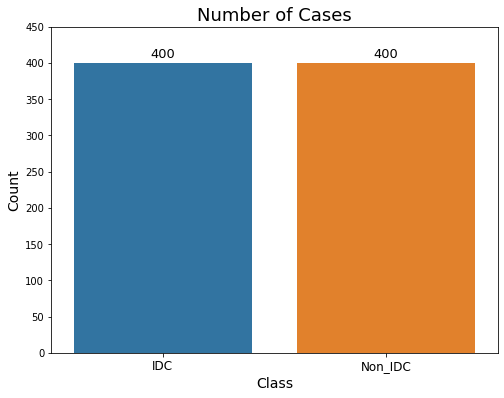

In [13]:
plt.figure(figsize=(8,6))
ax = sns.countplot(df_train_full['class_str'], data=df_train_full)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.title('Number of Cases', fontsize=18)
plt.ylim(0,450)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
               (p.get_x() + p.get_width()/2., 
                p.get_height()), ha='center', va='center', size=15, xytext=(0,9),
               textcoords = 'offset points', fontsize=13)

## Display 6 train images for each class


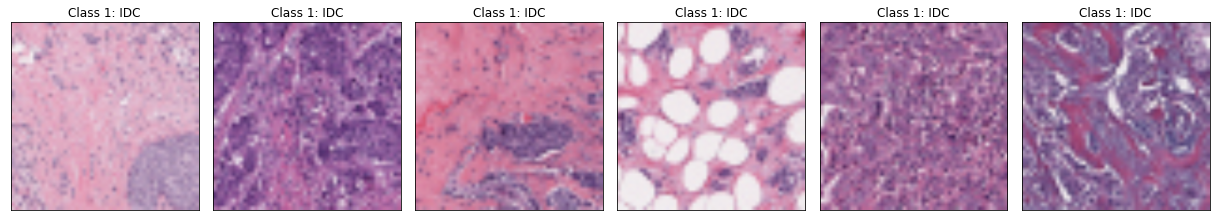

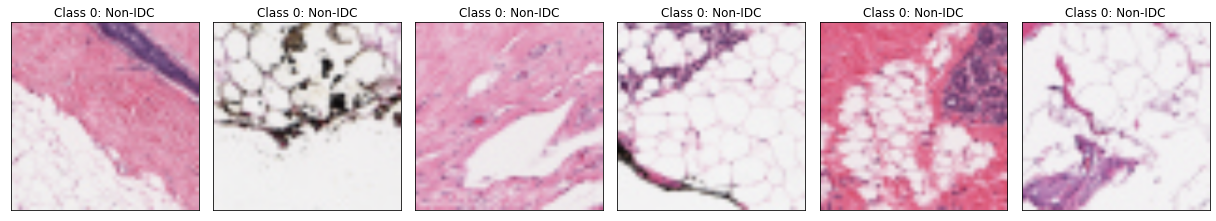

In [14]:
def display_images(subclass, class_name):
  fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(17,6))
  # images = []
  for idx, ax in enumerate(axes.flat):
    img = io.imread(subclass[idx])
    img = cv.resize(img, (224,224))    # resize an image from 50 by 50 to 512 by 512
    ax.imshow(img)
    ax.set_title(class_name)
    ax.set_xticks([])       # remove xticks passing an empty array
    ax.set_yticks([])       # remove yticks passing an empty array
  fig.tight_layout() 
  plt.show() 

display_images(train_class_1_w_path, 'Class 1: IDC')
display_images(train_class_0_w_path, 'Class 0: Non-IDC')

[Invasive ductal carcinoma (IDC) of the breast](https://www.mypathologyreport.ca/breast-invasive-ductal-carcinoma/)

In [15]:
# plt.imshow(cv.resize(io.imread('9383_idx5_x1951_y951_class1.png'), (80,80)))

## Store actual color images as a vector


In [16]:
# from skimage import color
def store_actual_images_to_grayscale(class_1_w_path, class_0_w_path):
  # read and store actual images (not the image paths) into the respective variable as a single vector then pass these to the model below
  image_pixels_class1 = [io.imread(img) for img in class_1_w_path]
  image_pixels_class0 = [io.imread(img) for img in class_0_w_path]
  full_image_pixels = np.asarray(image_pixels_class1 + image_pixels_class1)   # => (#samples, width, height)
  return image_pixels_class1, image_pixels_class0, full_image_pixels

In [17]:
# ======================================================================== #
# ===================== Store Train Images =============================== #
# ======================================================================== #
train_img_class1, train_img_class0, train_full_img = store_actual_images_to_grayscale(train_class_1_w_path, train_class_0_w_path)

print('Shape of each train image: ', train_img_class1[0].shape)
print('\nTotal number of images = ', len(train_full_img))
print('Number of class 1 images = ', len(train_img_class1))
print('Number of class 0 images = ', len(train_img_class0))
print('train_full_img = ', train_full_img.shape)

Shape of each train image:  (50, 50, 3)

Total number of images =  800
Number of class 1 images =  400
Number of class 0 images =  400
train_full_img =  (800, 50, 50, 3)


In [18]:
# ======================================================================== #
# ===================== Store Test Images ================================ #
# ======================================================================== #
test_img_class1, test_img_class0, test_full_img = store_actual_images_to_grayscale(test_class_1_w_path, test_class_0_w_path)

print('Shape of each test image: ', test_img_class1[0].shape)
print('\nTotal number of images = ', len(test_full_img))
print('Number of class 1 images = ', len(test_img_class1))
print('Number of class 0 images = ', len(test_img_class0))
print('test_full_img = ', test_full_img.shape)

Shape of each test image:  (50, 50, 3)

Total number of images =  200
Number of class 1 images =  100
Number of class 0 images =  100
test_full_img =  (200, 50, 50, 3)


In [19]:
# ======================================================================== #
# ===================== Store Validation Images ========================== #
# ======================================================================== #
val_img_class1, val_img_class0, val_full_img = store_actual_images_to_grayscale(val_class_1_w_path, val_class_0_w_path)

print('Shape of each validataion image: ', val_img_class1[0].shape)
print('\nTotal number of images = ', len(val_full_img))
print('Number of class 1 images = ', len(val_img_class1))
print('Number of class 0 images = ', len(val_img_class0))
print('val_full_img = ', val_full_img.shape)

Shape of each validataion image:  (50, 50, 3)

Total number of images =  200
Number of class 1 images =  100
Number of class 0 images =  100
val_full_img =  (200, 50, 50, 3)


## Image augmentation techniques on a training image

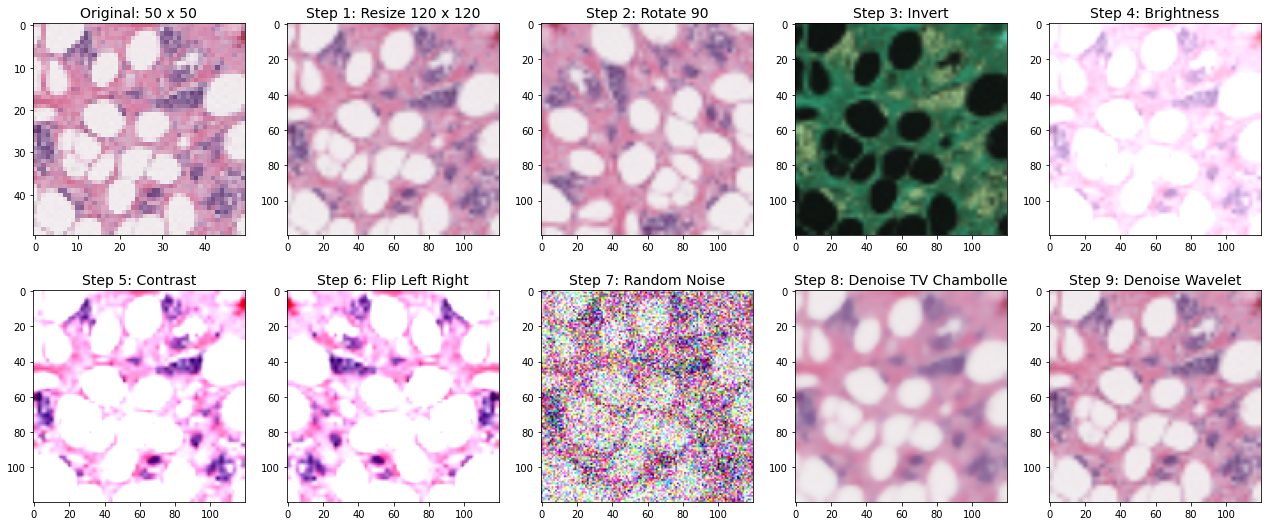

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage import util
from skimage.util import random_noise
from skimage.restoration import denoise_tv_chambolle, denoise_bilateral, denoise_wavelet, estimate_sigma

fig = plt.figure(figsize=(22,9))

# original image
original = io.imread(train_class_1_w_path[3])

# resized image
resized_img = cv.resize(train_img_class1[3], (120,120))

# pull an original image as is
ax = fig.add_subplot(2,5,1)
ax.imshow(original)
# ax.axis('off')
ax.set_title('Original: 50 x 50', size=14)

# resize an original image to 120 x 120
ax = fig.add_subplot(2,5,2)
ax.imshow(resized_img)                         
# ax.axis('off')
ax.set_title('Step 1: Resize 120 x 120', size=14)

# rotate an original image 90 degrees
ax = fig.add_subplot(2,5,3)
rot90_img = tf.image.rot90(resized_img, k=1)
ax.imshow(rot90_img)
# ax.axis('off')
ax.set_title('Step 2: Rotate 90', size=14)

# invert the resized image
ax = fig.add_subplot(2,5,4)
inverted_img = util.invert(resized_img)
plt.imshow(inverted_img);
# ax.axis('off')
ax.set_title('Step 3: Invert', size=14)

# adjust brightness of the resized image
ax = fig.add_subplot(2,5,5)
bright_img = tf.image.adjust_brightness(resized_img, 0.3)
plt.imshow(bright_img);
# ax.axis('off')
ax.set_title('Step 4: Brightness', size=14)

# adjust contrast of the brightened image
ax = fig.add_subplot(2,5,6)
contrast_img = tf.image.adjust_contrast(bright_img, contrast_factor=3)
plt.imshow(contrast_img);
# ax.axis('off')
ax.set_title('Step 5: Contrast', size=14)

# flip left right of the contrasted image
ax = fig.add_subplot(2,5,7)
flipped_img = tf.image.flip_left_right(contrast_img)
plt.imshow(flipped_img);
# ax.axis('off')
ax.set_title('Step 6: Flip Left Right', size=14)

# random noise: function to add random noise of various types to a floating-point image
ax = fig.add_subplot(2,5,8)
sigma = 0.355
noisy_img = random_noise(resized_img, var=sigma**2)
plt.imshow(noisy_img);
# ax.axis('off')
ax.set_title('Step 7: Random Noise', size=14)

# denoise_tv_chambolle: perform total-variation denoising on n-dimentional images
ax = fig.add_subplot(2,5,9)
dchambolle_img = denoise_tv_chambolle(resized_img, weight=0.1, multichannel=True)
plt.imshow(dchambolle_img);
# ax.axis('off')
ax.set_title('Step 8: Denoise TV Chambolle', size=14)

# denoise_wavelet:  perform wavelet denoising on an image
ax = fig.add_subplot(2,5,10)
dwavelet_img = denoise_wavelet(resized_img, multichannel=True)
plt.imshow(dwavelet_img);
# ax.axis('off')
ax.set_title('Step 9: Denoise Wavelet', size=14);

## Specify image data (X) and labels (y)

In [21]:
def define_X_and_y(data_pixels, df_data):
  X = data_pixels
  y = np.array(df_data['class']).flatten()   # no need to flatten here but maybe later on before I feed this to the model 
  return X, y

In [22]:
X_train, y_train = define_X_and_y(train_full_img, df_train_full)
X_test, y_test = define_X_and_y(test_full_img, df_test_full)
X_val, y_val = define_X_and_y(val_full_img, df_val_full)

print('X_train: ', X_train.shape, type(X_train))
print('X_test: ',X_test.shape, type(X_test))
print('X_val: ',X_val.shape, type(X_val))

X_train:  (800, 50, 50, 3) <class 'numpy.ndarray'>
X_test:  (200, 50, 50, 3) <class 'numpy.ndarray'>
X_val:  (200, 50, 50, 3) <class 'numpy.ndarray'>


## Randomize images (X) and labels (y) 


In [23]:
# print(X_train[0],'\n')
def shuffle_X_and_y(X, y):
  tf.random.set_seed(1234)
  np.random.seed(1234)
  shuffle = np.random.permutation(np.arange(X.shape[0]))      # randomize 
  return X[shuffle], y[shuffle]

In [24]:
X_train, y_train = shuffle_X_and_y(X_train, y_train)
X_test, y_test = shuffle_X_and_y(X_test, y_test)
X_val, y_val = shuffle_X_and_y(X_val, y_val)

print('y_val_shuffled:\n', y_val)
print('\ny_test_shuffled:\n', y_test)
print('\ny_train: total number of labels = ', len(y_train), type(y_train) ,'\n', y_train[:5], y_train[-5:])
print('\nX_train: total number of images = ', len(X_train), type(X_train), '\n', X_train[0])

y_val_shuffled:
 [0 0 1 1 1 1 1 1 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 1 1 0 1 0 0 1 1 0 0 0 0 0 1
 0 0 1 0 1 1 1 1 1 1 0 0 0 1 1 0 0 1 1 0 0 0 1 1 1 0 1 0 1 1 1 1 0 0 0 0 1
 1 1 0 1 0 1 1 1 1 0 0 0 0 1 1 1 1 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0 1 1 0 0 1
 1 1 0 1 1 1 1 0 0 0 1 0 0 0 1 0 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1 0 1 1 1
 1 1 1 1 1 0 0 1 0 1 1 1 0 0 1 1 0 0 0 1 1 1 0 1 0 0 0 1 1 1 1 0 0 1 1 0 0
 0 1 0 0 0 1 0 1 0 0 0 0 1 1 1]

y_test_shuffled:
 [0 0 1 1 1 1 1 1 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 1 1 0 1 0 0 1 1 0 0 0 0 0 1
 0 0 1 0 1 1 1 1 1 1 0 0 0 1 1 0 0 1 1 0 0 0 1 1 1 0 1 0 1 1 1 1 0 0 0 0 1
 1 1 0 1 0 1 1 1 1 0 0 0 0 1 1 1 1 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0 1 1 0 0 1
 1 1 0 1 1 1 1 0 0 0 1 0 0 0 1 0 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1 0 1 1 1
 1 1 1 1 1 0 0 1 0 1 1 1 0 0 1 1 0 0 0 1 1 1 0 1 0 0 0 1 1 1 1 0 0 1 1 0 0
 0 1 0 0 0 1 0 1 0 0 0 0 1 1 1]

y_train: total number of labels =  800 <class 'numpy.ndarray'> 
 [1 1 0 1 0] [1 1 1 1 0]

X_train: total number of images =  800 <class 'numpy.ndarra

## Resize images from (50, 50) to (80, 80) on X

In [25]:
image_size = (50,50)
X_train = tf.image.resize(X_train, size=image_size)
X_test = tf.image.resize(X_test, size=image_size)
X_val = tf.image.resize(X_val, size=image_size)
print(type(X_train), X_train.shape)
print('\nX_train[0]:\n',X_train[0])


<class 'tensorflow.python.framework.ops.EagerTensor'> (800, 50, 50, 3)

X_train[0]:
 tf.Tensor(
[[[217. 140. 172.]
  [218. 158. 188.]
  [216. 144. 178.]
  ...
  [205. 139. 176.]
  [208. 145. 179.]
  [174. 123. 165.]]

 [[218. 148. 178.]
  [213. 156. 191.]
  [216. 147. 178.]
  ...
  [212. 139. 172.]
  [201. 132. 166.]
  [148. 108. 156.]]

 [[212. 150. 181.]
  [214. 150. 180.]
  [216. 137. 171.]
  ...
  [210. 134. 169.]
  [170. 116. 158.]
  [193. 152. 180.]]

 ...

 [[194. 145. 181.]
  [183. 134. 174.]
  [119.  85. 132.]
  ...
  [168. 119. 162.]
  [157. 106. 147.]
  [189. 159. 189.]]

 [[197. 143. 176.]
  [167. 123. 169.]
  [147.  98. 145.]
  ...
  [187. 145. 182.]
  [193. 150. 184.]
  [191. 135. 176.]]

 [[178. 132. 174.]
  [165. 124. 162.]
  [171. 126. 169.]
  ...
  [200. 150. 179.]
  [199. 141. 175.]
  [202. 126. 167.]]], shape=(50, 50, 3), dtype=float32)


## Convert to gray scale and normalize images
Rescale images to [0,1]

In [26]:
X_train = tf.image.rgb_to_grayscale(X_train)/255.0
X_test = tf.image.rgb_to_grayscale(X_test)/255.0
X_val = tf.image.rgb_to_grayscale(X_val)/255.0
print(X_train.shape)
# print(X_train[0])

(800, 50, 50, 1)


## Image augmentation on training images
- Adjust brightness
- Adjust contrast
- Flip left and right
- Rotate 90 degrees

In [27]:
brightness_delta = 0.3
contrast_factor = 3
rot_degree = 1               # rotate mapping => key:val = angle:k = {90:1, 180:2, 270:3}

# add a set of augmented images to X_train_norm rather than overwrite the existing ones
X_train_bright = tf.image.adjust_brightness(X_train, delta=brightness_delta)
X_train_contrast = tf.image.adjust_contrast(X_train, contrast_factor=contrast_factor)
X_train_flip = tf.image.random_flip_left_right(X_train)
X_train_rot90 = tf.image.rot90(X_train, k=rot_degree)            
# X_train_invert = util.invert(X_train)
# X_train_noise = random_noise(X_train, var=0.355**2)   # sigma = 0.355
# dchambolle_img = denoise_tv_chambolle(X_train, weight=0.1, multichannel=True)
# X_train_dwavelet = denoise_wavelet(X_train, multichannel=True)

## Merge original training images with the augmented images

In [28]:
# # concatenate X_train_final with augmented X_train
# X_train = tf.concat([X_train, 
#                     X_train_bright, 
#                     X_train_contrast, 
#                     X_train_flip,
#                     X_train_rot90], axis=0)
# print('X_train with augmentation: ', X_train.shape)

# # concatenate y_train (the label is preserved)
# y_train = y_train
# y_train_bright, y_train_contrast, y_train_flip, y_train_rot90 = y_train, y_train, y_train, y_train
# y_train = tf.concat([y_train, 
#                     y_train_bright, 
#                     y_train_contrast, 
#                     y_train_flip,
#                     y_train_rot90], axis=0)
# print('y_train_bright: ', y_train_bright.shape)
# print('y_train with augmentation: ', y_train.shape)

## Shuffle X_train and y_train
Shuffle two tensors in the same order

In [29]:
print(tf.shape(X_train))
shuffle1 = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
X_train = tf.gather(X_train, shuffle1)
y_train = tf.gather(y_train, shuffle1).numpy()  # also transforms y_train to numpy array

shuffle2 = tf.random.shuffle(tf.range(tf.shape(X_val)[0], dtype=tf.int32))
X_val = tf.gather(X_val, shuffle2)
y_val = tf.gather(y_val, shuffle2).numpy()  # also transforms y_train to numpy array

tf.Tensor([800  50  50   1], shape=(4,), dtype=int32)


In [30]:
print(X_train[0][1][1])
print(y_train[:100])

tf.Tensor([0.73650986], shape=(1,), dtype=float32)
[0 0 1 1 1 0 0 1 0 1 0 0 0 0 1 0 0 1 1 1 0 0 1 0 1 0 1 0 0 0 1 1 0 0 0 1 0
 1 1 0 0 0 0 1 1 0 1 0 1 1 1 1 0 0 0 1 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 1 1
 0 1 1 0 1 0 0 1 0 0 0 0 0 1 1 1 0 0 0 1 0 1 0 0 1 1]


## Display the first 10 train and validation examples with the label of each example as the title

Print training data examples:


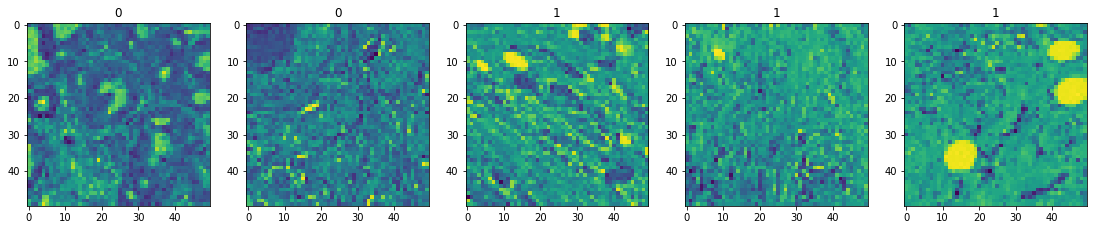

In [31]:
print('Print training data examples:')
nrows, ncols = 1,5 
f, axs = plt.subplots(nrows, ncols, figsize=(19,15))
for i in range(ncols):
    axs[i].imshow(array_to_img(X_train[i]))
    axs[i].set(title=y_train[i])

Print validation data examples:


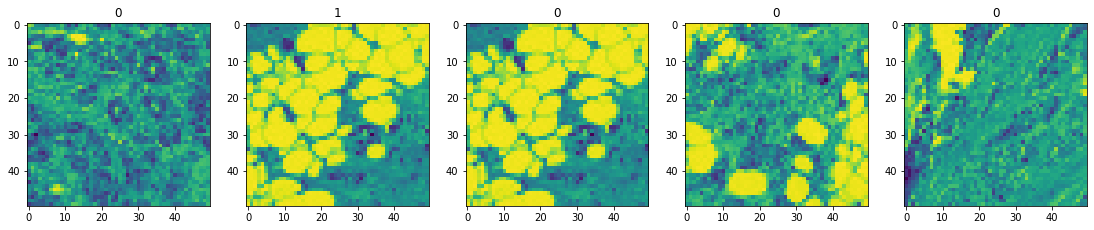

In [32]:
# print validation data
print('Print validation data examples:')
nrows, ncols = 1,5 
f, axs = plt.subplots(nrows, ncols, figsize=(19,15))
for i in range(ncols):
    axs[i].imshow(array_to_img(X_val[i]))
    axs[i].set(title=y_val[i])

## CNN Model using Tensorflow Keras API<br>
1) Build model<br>
2) Compile model<br>
3) Fit model

In [33]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

input_shape = (50,50,1)
filters_1 = 32
filters_2 = 64
filters_3 = 64
kernel_size = (3,3)
pool_size = (2,2)
strides = (1, 1)
fully_connected_layer_units = 256
dropout_rate = 0.3

# 1)  Build model
def build_model(activation='tanh',
                optimizer='SGD',
                learning_rate=0.01):
  
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  # Building the CNN
  model = Sequential()      # initialize the model using Sequential(), which indicates our network will be stacked with different layers

  # Define activation function
  if activation.lower() == 'leakyrelu':
    activation = tf.keras.layers.LeakyReLU(alpha=0.3)    # alpha = Float >= 0. Negative slope coefficient. Default to 0.3
  
  # Add the convolutional layers
  model.add(Conv2D(filters=filters_1, kernel_size=kernel_size, activation=activation, padding='same', input_shape=input_shape))                  # 1st convolutional layer
  model.add(MaxPooling2D(pool_size=pool_size, strides=strides))                                                                                 # 1st Pooling
  # model.add(Conv2D(filters=filters_2, kernel_size=kernel_size, activation=activation, padding='same'))                                           # 2nd convolutional layer
  # model.add(MaxPooling2D(pool_size=pool_size, strides=strides))                                                                                 # 2nd Pooling
  # model.add(Conv2D(filters=filters_3, kernel_size=kernel_size, activation=activation, padding='same'))                                           # 3rd convolutional layer
  # model.add(MaxPooling2D(pool_size=pool_size, strides=strides))                                                                                 # 3rd Pooling

  # Flatten the dataset to feed into a fully connected layer
  model.add(Flatten())    

  # Fully connected layer
  model.add(Dense(units=fully_connected_layer_units,                 # This can be adjusted (a hyper param)
                  activation=activation))                            # For the first layer: the number of units or neurons

  # Dropout layer
  # model.add(Dropout(rate=dropout_rate))
  
  # Output layer
  model.add(Dense(
        units=2,                                   # units=1; binary output dimension (only one neuron)
        # use_bias=True,                           # Alternative: use_bias=False
        activation='softmax'))                     # activation='sigmoid'

  if optimizer.lower() == 'adam':
    optimizer = Adam(learning_rate=learning_rate)
  elif optimizer.lower() == 'sgd':
    optimizer = SGD(learning_rate=learning_rate)   

# 2) Compile Model
  # model.compile(loss=BinaryCrossentropy(from_logits=True),             # for a binary classification
  #               optimizer=optimizer,                    # used to change the attributes of a neural network such as weights and learning rate to reduce the losses.
  #               metrics=['accuracy'])  
  model.compile(loss=SparseCategoricalCrossentropy(),             # BinaryCrossentropy(): for a binary classification
                optimizer=optimizer,                    # used to change the attributes of a neural network such as weights and learning rate to reduce the losses.
                metrics=['accuracy'])           
  print(f'CNN Model:\nActivation = {activation}\nOptimizer = {optimizer}\nlearning_rate = {learning_rate}\n')
  return model

In [34]:
learning_rate = 0.01
activation='relu'
optimizer='sgd'

model = build_model(activation=activation,              # relu, leakyrelu, tanh, sigmoid
                optimizer=optimizer,                    # adam, [SGD]        
                learning_rate=learning_rate)        # 0.1, 0.01, 0.001
model.summary()

CNN Model:
Activation = relu
Optimizer = <keras.optimizer_v2.gradient_descent.SGD object at 0x7fb1291f1590>
learning_rate = 0.01

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 76832)             0         
                                                                 
 dense (Dense)               (None, 256)               19669248  
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                          

### 3) Fit Model

In [35]:
num_epochs = 10
batch_size = 16

print(f'Hyperparameters: \
      \n\ttraining_sample_size = {training_sample_size} \
      \n\tnum_epochs = {num_epochs} \
      \n\tbatch_size = {batch_size} \
      \n\timage_size = {image_size} \
      \n\tinput_shape = {input_shape} \
      \n\tfilters_1 = {filters_1} \
      \n\tfilters_2 = {filters_2} \
      \n\tfilters_3 = {filters_3} \
      \n\tfully_connected_layer_units = {fully_connected_layer_units} \
      \n\tkernel_size = {kernel_size} \
      \n\tpool_size = {pool_size} \
      \n\tstrides = {strides} \
      \n\tlearning_rate = {learning_rate} \
      \n\tactivation = {activation} \
      \n\toptimizer = {optimizer} \
      \n\nImage Agumentation Params: \
      \n\tbrightness_delta = {brightness_delta} \
      \n\tcontrast_factor = {contrast_factor} \
      \n\trot_degree = {rot_degree}\n')


tf.random.set_seed(1234)
np.random.seed(1234)

history = model.fit(X_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    validation_data = (X_val, y_val))

Hyperparameters:       
	training_sample_size = 800       
	num_epochs = 10       
	batch_size = 16       
	image_size = (50, 50)       
	input_shape = (50, 50, 1)       
	filters_1 = 32       
	filters_2 = 64       
	filters_3 = 64       
	fully_connected_layer_units = 256       
	kernel_size = (3, 3)       
	pool_size = (2, 2)       
	strides = (1, 1)       
	learning_rate = 0.01       
	activation = relu       
	optimizer = sgd       

Image Agumentation Params:       
	brightness_delta = 0.3       
	contrast_factor = 3       
	rot_degree = 1

Epoch 1/10
50/50 [==============================] - 21s 390ms/step - loss: 0.7004 - accuracy: 0.5013 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 2/10
50/50 [==============================] - 13s 269ms/step - loss: 0.6951 - accuracy: 0.4988 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 3/10
50/50 [==============================] - 10s 193ms/step - loss: 0.6941 - accuracy: 0.4737 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/10
50/50 [

## Plot loss and accuracy for training and validation sets

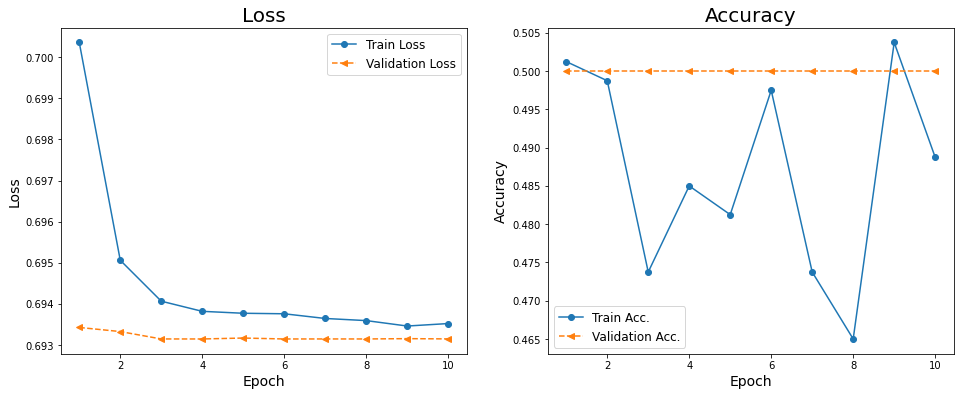

In [36]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1
# print(x_arr)

fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(1,2,1)
ax.plot(x_arr, hist['loss'], '-o', label='Train Loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation Loss')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=14)
ax.set_ylabel('Loss', size=14)
ax.set_title('Loss', size=20)

ax = fig.add_subplot(1,2,2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train Acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation Acc.')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=14)
ax.set_ylabel('Accuracy', size=14)
ax.set_title('Accuracy', size=20);

## Model Evaluation

In [37]:
eval_test = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {eval_test[1]*100:.2f}%\n')

eval_train = model.evaluate(X_train, y_train)
print(f'Train Accuracy: {eval_train[1]*100:.2f}%')

7/7 [==============================] - 0s 54ms/step - loss: 0.6931 - accuracy: 0.5000
Test Accuracy: 50.00%

25/25 [==============================] - 2s 59ms/step - loss: 0.6931 - accuracy: 0.5000
Train Accuracy: 50.00%


## Model Prediction

In [38]:
# Transform logits to probabilities
pred_logits = model.predict(X_test)
probabilities = tf.sigmoid(pred_logits)
probabilities = probabilities.numpy().flatten()*100
# print(probabilities)

## Plot Test vs. Predicted

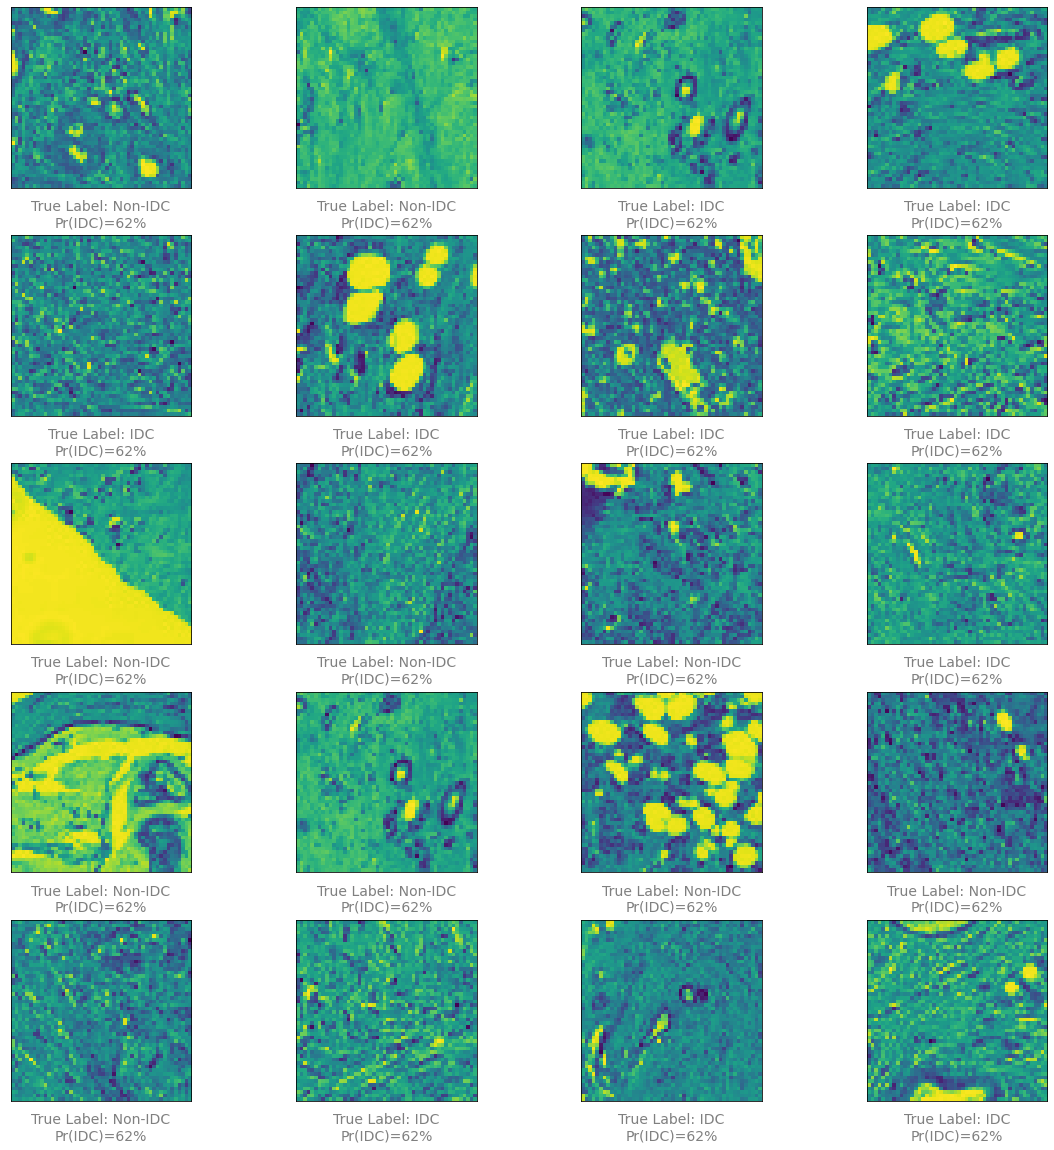

In [39]:
fig = plt.figure(figsize=(16,25))

for j, example in enumerate(X_test[:20]):
    ax = fig.add_subplot(8,4, j+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(array_to_img(example))
    if y_test[j]==0:
        label='Non-IDC'
    else:
        label='IDC'
    
    ax.text(
        0.5, -0.15, 
        'True Label: {:s}\nPr(IDC)={:.0f}%'.format(label, probabilities[j]), 
        size=14, 
        color='grey',
        horizontalalignment='center',
        verticalalignment='center', 
        transform=ax.transAxes)
    
plt.tight_layout()
plt.show()

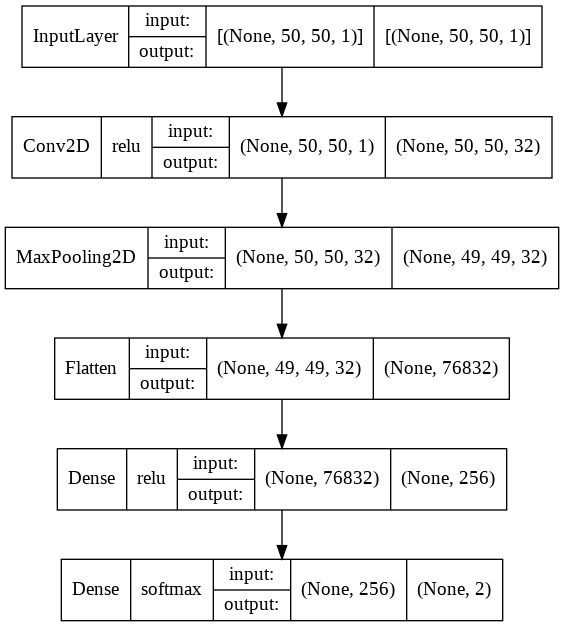

In [40]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=False,
    show_layer_activations=True,
)

# 2. Prediction the most common area that may be detected IDC using patch locations



## Extract features from file names

In [41]:
# def extract_features(file_list): 
#   features = []
#   for file in file_list:
#     str_feat = re.findall(r'\d+', file)
#     int_feat = [int(feat) for feat in str_feat]
#     features.append(int_feat)
#   df_feat = pd.DataFrame(features, columns=['patient_id', 'd', 'x_coord', 'y_coord', 'class']).drop('d', axis=1)
#   df_feat['patch_coord'] = list(zip(df_feat.x_coord, df_feat.y_coord))
#   return df_feat[['patient_id','x_coord', 'y_coord', 'patch_coord','class']]


# df_features = extract_features(full_data_wo_path)
# print(df_features.shape)
# display(df_features.head().append(df_features.tail()))

In [42]:
# df_features.info()

## Randomize data 
: As we may use SGD for training, we will randomize sample of the data for each batch so that the gradient computed is representative.

In [43]:
# indexes = np.arange(df_features.shape[0])
# print('indexes:', indexes)

# np.random.seed(0)    # get the same results each time    ??????
# shuffled_indexes = np.random.permutation(indexes)
# print('shuffled indexes:', shuffled_indexes, '\n')

# # change the ordering of the original df_features using .reindex()
# df_features = df_features.reindex(shuffled_indexes)
# display(df_features)

## Train/Test split (80/20) & Feature Selection

In [44]:
# split_boundary = int(df_features.shape[0]*.8)

# train = pd.DataFrame(df_features.iloc[:split_boundary, 3:])
# test = pd.DataFrame(df_features.iloc[split_boundary:, 3:])

# print('Train Shape: ', train.shape, '\n', train.head(3))
# print('\nTest Shape: ', test.shape, '\n', test.head(3))